# Engineering Modeling and Design Optimization

## Modeling Noisy Data using Regression Kriging

Adding simulated gaussian noise to the xsinx function and modelling using regression kriging

In [1]:
import numpy as np
from smt.surrogate_models import KRG, RBF
from smt.problems import TorsionVibration, CantileverBeam, WingWeight
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from scipy.stats import norm

In [2]:
# Defining the noisy xsinx function
forrester = lambda x: x*np.sin(x) + norm.rvs(scale = 1.0, size=x.shape)

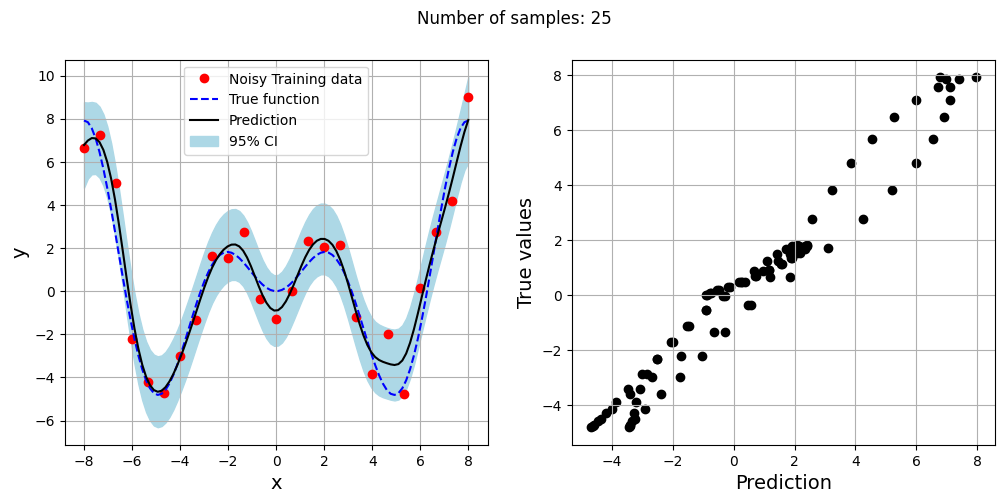

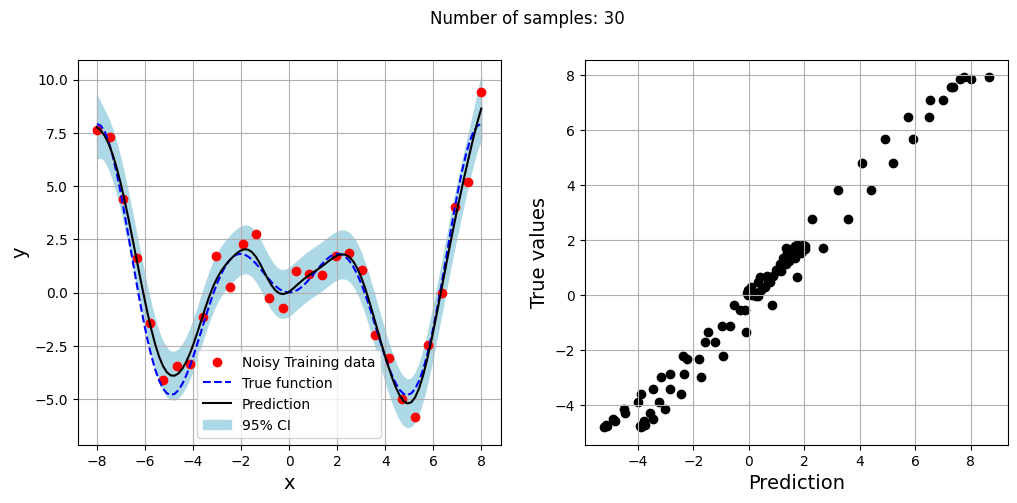

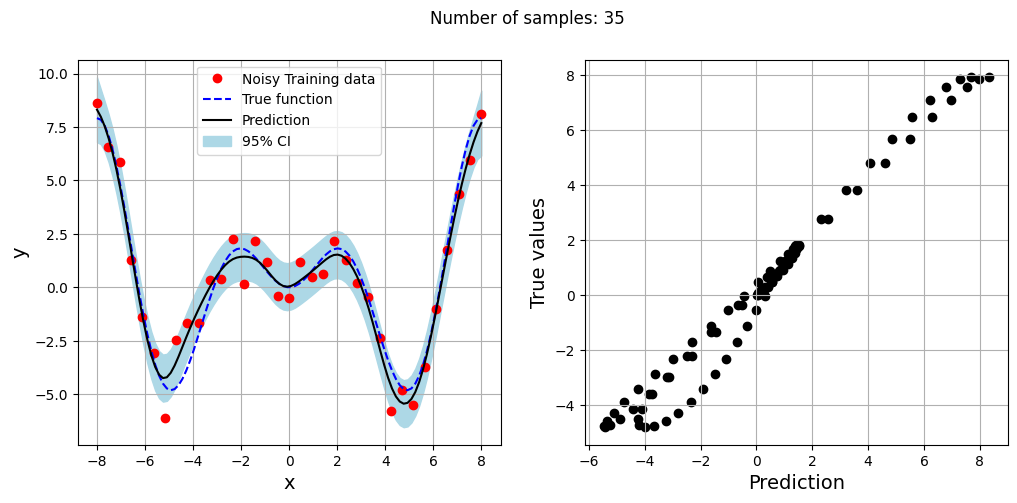

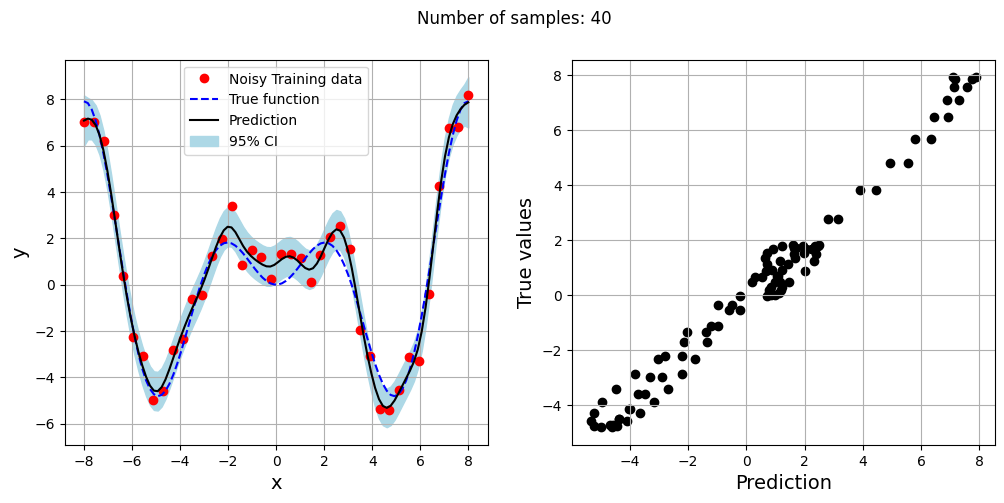

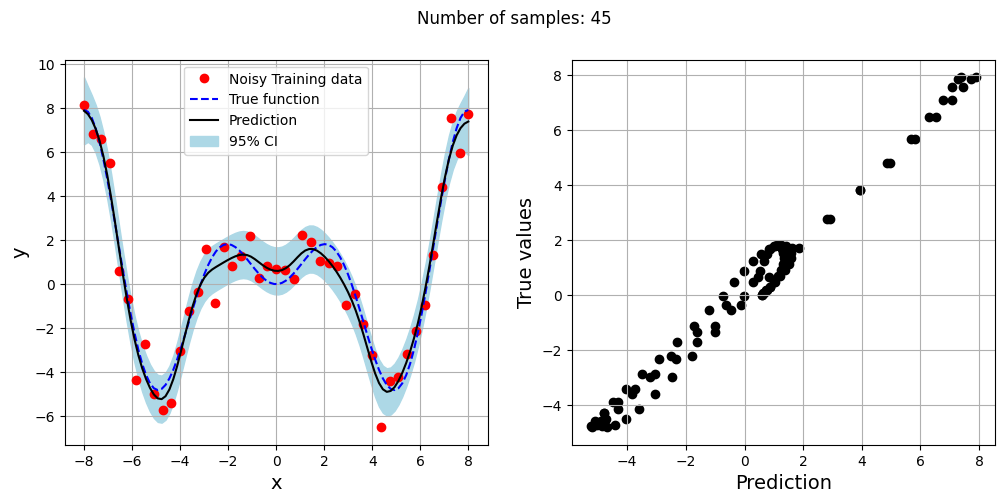

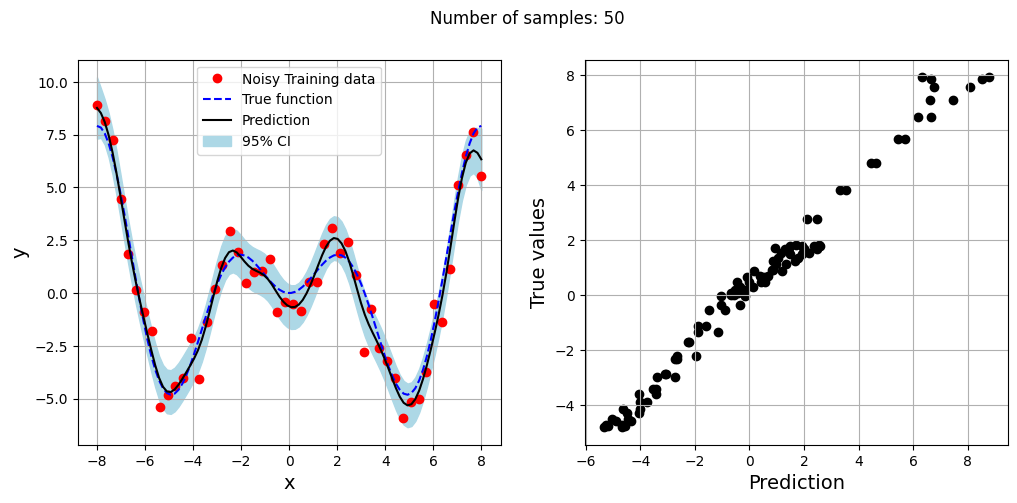

In [3]:
# Plotting data
xplot = np.linspace(-8, 8, 100)
yplot = xplot * np.sin(xplot)

# Creating array of training sample sizes
samples = np.array([25,30,35,40,45,50])

# Initializing nrmse list
nrmse = []

# Fitting with different sample size
for sample in samples:
    
    xtrain = np.linspace(-8, 8, sample)
    ytrain = forrester(xtrain)
    
    # Fitting the kriging
    sm = KRG(theta0=[1e-2], corr='matern52', theta_bounds=[1e-6, 1e2], print_global=False, eval_noise = True)
    sm.set_training_values(xtrain, ytrain)
    sm.train()
    
    # Predict at test values
    yplot_pred = sm.predict_values(xplot).reshape(-1,)
    yplot_var = sm.predict_variances(xplot).reshape(-1,)

    # Calculating average nrmse
    nrmse.append(np.sqrt(mean_squared_error(yplot, yplot_pred)) / np.ptp(yplot))
    
    # Plotting prediction
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    ax[0].plot(xtrain, ytrain, 'ro', label='Noisy Training data')
    ax[0].plot(xplot, yplot, 'b--', label='True function')
    ax[0].plot(xplot, yplot_pred, 'k', label='Prediction')
    ax[0].fill_between(xplot, yplot_pred - 2*np.sqrt(yplot_var), yplot_pred + 2*np.sqrt(yplot_var), color='lightblue', label='95% CI')
    ax[0].set_xlabel("x", fontsize=14)
    ax[0].set_ylabel("y", fontsize=14)
    ax[0].grid()
    ax[0].legend()
    
    ax[1].scatter(yplot_pred, yplot, c="k")
    ax[1].set_xlabel("Prediction", fontsize=14)
    ax[1].set_ylabel("True values", fontsize=14)
    ax[1].grid()
    
    fig.suptitle("Number of samples: {}".format(sample))

## Feature Scaling for engineering modeling

## Modeling the Torsion Vibration problem from SMT using RBF

Scale of design variables vary from 1e+07 to 1e-02

In [13]:
# Defining the Torsion Vibration problem
ndim = 15
problem = TorsionVibration(ndim=ndim)

Setting up the training and testing data along with the standard scaler

In [5]:
def find_sigma(x_train, y_train, x_test, y_test, sigmas, xstd_scaler = None, ystd_scaler = None):
    """
    This function finds the best sigma for a RBF model by fitting the model to the training data and
    evaluating it on testing data. The best sigma is the one that achieves minimum normalized RMSE.

    Parameters
    ----------
    x_train : numpy array
        Training data x values
    y_train : numpy array
        Training data y values
    x_test : numpy array
        Testing data x values
    y_test : numpy array
        Testing data y values
    sigmas : numpy array
        Sigmas to be tested

    Returns
    -------
    best_sigma : float
        Best sigma value
    metric : list
        List of NRMSE values for each sigma
    """

    # Initializing normalized RMSE list
    metric = []

    # Fitting various polynomials
    for sigma in sigmas:

        # Fit the RBF to current fold
        sm = RBF(d0=sigma, poly_degree=-1, print_global=False)
        sm.set_training_values(x_train, y_train)
        sm.train()

        # Predict at test values
        if xstd_scaler is not None and ystd_scaler is not None:
            y_pred = sm.predict_values(xstd_scaler.transform(x_test))
            y_pred = ystd_scaler.inverse_transform(y_pred)
        else:
            y_pred = sm.predict_values(x_test)

        # Adding all the rmse to calculate average later
        nrmse = np.sqrt(mean_squared_error(y_test, y_pred)) / np.ptp(y_test)
            
        # Calculating average nrmse
        metric.append(nrmse)

    best_sigma = sigmas[np.argmin(metric)]

    return best_sigma, metric

In [6]:
# Creating testing data for the problem
test_sampler = FullFactorial(xlimits=problem.xlimits)
num_test = 100
xtest = test_sampler(num_test)
ytest = problem(xtest)

# Standard scaling
xstd_scaler = StandardScaler()
ystd_scaler = StandardScaler()

# Fitting with different sample size
train_sampler = LHS(xlimits=problem.xlimits, criterion="ese")

# Defining the number of samples
samples = [5,10,15,20,25,30,35,40,45,50]

scaled_nrmse = []
nrmse = []

for sample in samples:
    # Creating a model with and without scaling
    num = sample
    xtrain = train_sampler(num)
    ytrain = problem(xtrain)
    
    xtrain_scaled = xstd_scaler.fit_transform(xtrain)
    ytrain_scaled = ystd_scaler.fit_transform(ytrain)
    
    sigmas = np.logspace(-15, 15, 1000)
    best_sigma, test_metric = find_sigma(xtrain, ytrain, xtest, ytest, sigmas, xstd_scaler=None, ystd_scaler=None)
    best_sigma_scaled, test_metric_scaled = find_sigma(xtrain_scaled, ytrain_scaled, xtest, ytest, sigmas, xstd_scaler, ystd_scaler)
    
    # Fitting RBF using scaled data
    sm_scaled = RBF(d0=best_sigma_scaled, print_global = False)
    sm_scaled.set_training_values(xtrain_scaled, ytrain_scaled)
    sm_scaled.train()
    
    # Fitting RBF using unscaled data
    sm = RBF(d0=best_sigma, print_global = False)
    sm.set_training_values(xtrain, ytrain)
    sm.train()
    
    # Predicting on test data
    ypred_scaled = sm_scaled.predict_values(xstd_scaler.transform(xtest))
    ypred_scaled = ystd_scaler.inverse_transform(ypred_scaled)
    ypred = sm.predict_values(xtest)

    scaled_nrmse.append(np.sqrt(mean_squared_error(ytest, ypred_scaled)) / np.ptp(ytest))
    nrmse.append(np.sqrt(mean_squared_error(ytest, ypred)) / np.ptp(ytest))

Text(0, 0.5, 'Normalized RMSE')

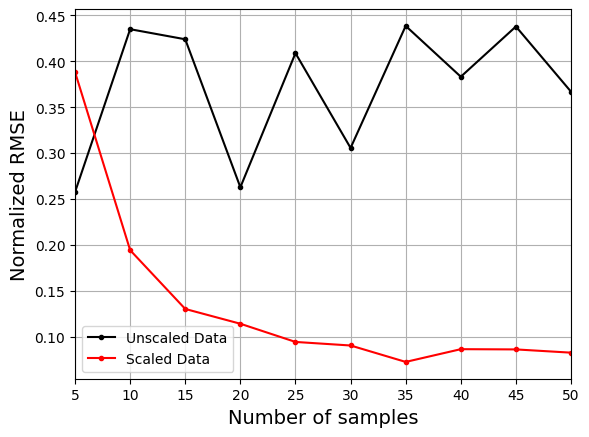

In [7]:
# Plotting NMRSE
fig, ax = plt.subplots()
ax.plot(samples, np.array(nrmse), c="k", marker=".", label = "Unscaled Data")
ax.plot(samples, np.array(scaled_nrmse), c="r", marker=".", label = "Scaled Data")
ax.grid(which="both")
ax.legend()
ax.set_xlim((samples[0], samples[-1]))
ax.set_xlabel("Number of samples", fontsize=14)
ax.set_ylabel("Normalized RMSE", fontsize=14)

## Exploitation of unconstrained modified Branin function using RBF model

Using scaled and unscaled data

In [8]:
def modified_branin(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    a = 1.
    b = 5.1 / (4.*np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8.*np.pi)

    y = a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*np.cos(x1) + s + 5*x1

    if dim == 1:
        y = y.reshape(-1)

    return y

# Bounds
lb = np.array([-5, 0])
ub = np.array([10, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ))
num_test = 100
xtest = sampler(num_test)
ytest = modified_branin(xtest)


### Using unscaled version of the data

In [9]:
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False

# Problem class
class Exploitation(Problem):

    def __init__(self, sm):
        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = self.sm.predict_values(x)

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

In [10]:
sampler = LHS(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese', random_state = 45)

# Training data
num_train = 20
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)

# Variables
itr = 0
max_itr = 30
tol = 5e-3
delta_f = [1]
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < delta_f[-1]:
    
    print("\nIteration {}".format(itr + 1))

    sigmas = np.logspace(-5, 5, 100)
    best_sigma, test_metric = find_sigma(xtrain, ytrain, xtest, ytest, sigmas)

    # Initializing the kriging model
    sm = RBF(d0=best_sigma, print_global=False)

    # Setting the training values
    sm.set_training_values(xtrain, ytrain)
    
    # Creating surrogate model
    sm.train()

    # Find the minimum of surrogate model
    result = minimize(Exploitation(sm), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))

    if itr == 0:
        delta_f = [np.abs(result.F - y_infill)/np.abs(result.F)]
    else:
        delta_f = np.append(delta_f, np.abs(result.F - y_infill)/np.abs(result.F))
    
    print("Change in f: {}".format(delta_f[-1]))
    print("f*: {}".format(y_infill))
    print("x*: {}".format(result.X))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest obtained point:")
print("x*: {}".format(xtrain[np.argmin(ytrain)]))
print("f*: {}".format(np.min(ytrain)))


Iteration 1
Change in f: [0.86363425]
f*: [-7.49170155]
x*: [-4.99999993 14.99999999]

Iteration 2
Change in f: 0.4650742769067305
f*: [-7.14189051]
x*: [-4.99999131 14.92141564]

Iteration 3
Change in f: 0.10969420294742016
f*: [-12.3319303]
x*: [-4.36136831 13.73228963]

Iteration 4
Change in f: 0.06977226444213074
f*: [-12.27345055]
x*: [-4.35391747 13.68575025]

Iteration 5
Change in f: 0.04883276370440886
f*: [-12.22820958]
x*: [-4.35352576 13.67091625]

Iteration 6
Change in f: 0.03701170306520387
f*: [-12.20263557]
x*: [-4.35122221 13.65450544]

Iteration 7
Change in f: 0.027827491396385576
f*: [-12.16658083]
x*: [-4.35285117 13.65034007]

Iteration 8
Change in f: 0.02454071417509867
f*: [-12.17471211]
x*: [-4.34973578 13.64064017]

Iteration 9
Change in f: 0.020906584754386125
f*: [-12.16803629]
x*: [-4.34897931 13.63578379]

Iteration 10
Change in f: 0.01836876593377306
f*: [-12.16557879]
x*: [-4.34835039 13.6326435 ]

Iteration 11
Change in f: 0.014949850019911493
f*: [-12.1

### Using scaled version of the data

In [11]:
# Problem class
class Exploitation(Problem):

    def __init__(self, sm, xscaler, yscaler):
        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model
        self.xscaler = xscaler
        self.yscaler = yscaler

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = self.yscaler.inverse_transform(self.sm.predict_values(self.xscaler.transform(x)))

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

In [12]:
sampler = LHS(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese', random_state=45)

# Training data
num_train = 20
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain).reshape(-1,1)

# Variables
itr = 0
max_itr = 30
tol = 5e-3
delta_f = [1]

# Sequential sampling Loop
while itr < max_itr and tol < delta_f[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Standard scaling
    xstd_scaler = StandardScaler()
    ystd_scaler = StandardScaler()

    xtrain_scaled = xstd_scaler.fit_transform(xtrain)
    if ytrain.ndim == 1:
        ytrain = ytrain.reshape(-1,1)
    ytrain_scaled = ystd_scaler.fit_transform(ytrain)

    sigmas = np.logspace(-15, 15, 100)
    best_sigma, test_metric = find_sigma(xtrain_scaled, ytrain_scaled, xtest, ytest, sigmas, xstd_scaler, ystd_scaler)

    # Initializing the kriging model
    sm = RBF(d0=best_sigma, print_global=False)

    # Setting the training values
    sm.set_training_values(xtrain_scaled, ytrain_scaled)
    
    # Creating surrogate model
    sm.train()

    # Find the minimum of surrogate model
    result = minimize(Exploitation(sm, xstd_scaler, ystd_scaler), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))

    if itr == 0:
        delta_f = [np.abs(result.F - y_infill)/np.abs(result.F)]
    else:
        delta_f = np.append(delta_f, np.abs(result.F - y_infill)/np.abs(result.F))
    
    print("Change in f: {}".format(delta_f[-1]))
    print("f*: {}".format(y_infill))
    print("x*: {}".format(result.X))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )

    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest obtained point:")
print("x*: {}".format(xtrain[np.argmin(ytrain)]))
print("f*: {}".format(np.min(ytrain)))


Iteration 1
Change in f: [0.86856496]
f*: [-7.49169803]
x*: [-4.99999963 14.99999803]

Iteration 2
Change in f: 0.5288107812469868
f*: [-6.96336929]
x*: [-4.99999926 14.88238972]

Iteration 3
Change in f: 0.10983366880321722
f*: [-13.51045921]
x*: [-4.19433928 13.45952555]

Iteration 4
Change in f: 0.05758309736691329
f*: [-13.28724528]
x*: [-4.20483707 13.42580719]

Iteration 5
Change in f: 0.032865315729798394
f*: [-13.14077589]
x*: [-4.21575086 13.42023204]

Iteration 6
Change in f: 0.017218983215701894
f*: [-13.02067865]
x*: [-4.22382561 13.41308292]

Iteration 7
Change in f: 0.011637389623782728
f*: [-12.98932386]
x*: [-4.22555973 13.40991264]

Iteration 8
Change in f: 0.006080036880136135
f*: [-12.94762764]
x*: [-4.22833882 13.40753891]

Iteration 9
Change in f: 0.0034229314140226843
f*: [-12.93429573]
x*: [-4.22816109 13.40279174]

Best obtained point:
x*: [-4.19433928 13.45952555]
f*: -13.510459205242743
